# Sentiment Analysis

## 04. BERT-based Model

In this notebook is the sentiment classifier using the BERT-based cased model. This model performed the best, I suspect since casing impacted the emotional tone of the sentence. I will be using the architecture and parameters found while finetuning the model, but this time with an increased dataset and sequence length.

### Libraries

Firstly, installing transformers, which isn't in Colab initially.

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.3 MB/s eta 0:00:00


Importing the necessary libraries.

In [3]:
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

# Math, String, etc
from pylab import rcParams
import sys
import re
import os
import string
import time
import datetime
import random
import math
import copy

# Testing and metrics
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import make_scorer, accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# BERT
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, logging
logging.set_verbosity_error()

# Metal to run it locally on apple silicon, it falls back to CUDA online, else CPU as final resort
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

Checking that the GPU is activated.

In [4]:
print(torch.cuda.is_available())

True


Defining the function for reproducibility.

In [5]:
def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

### Data Preprocessing & Preparation

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initially using a smaller portion of the data for training to make sure everything is working correctly.

In [8]:
# Using \t as delimeter and reading with pandas 
df = pd.read_csv("/imdb-reviews.csv", sep = '\t')
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# I will reserve 8% of the samples for testing and 10% for validation
train_X, val_X, test_X = X[:int(len(X)*0.32)], X[int(len(X)*0.32):int(len(X)*0.42)], X[int(len(X)*0.42):int(len(X)*0.5)]
train_Y, val_Y, test_Y = Y[:int(len(Y)*0.32)], Y[int(len(Y)*0.32):int(len(Y)*0.42)], Y[int(len(Y)*0.42):int(len(Y)*0.5)]

# Unique returns the mapping sorted
labelsMapping, indexed_labels_train = np.unique(train_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_Y['rating'], return_inverse=True)

Loading the corresponding BERT tokenizer.

In [11]:
# Load the BERT tokenizer Cased
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Function to preprocess the reviews by applying the BERT tokenizer's encode_plus method to tokenize and pad the review to prepare the data for the BERT-based model. The function returns the input IDs and attention masks as PyTorch tensors.

In [12]:
# Returns input_ids and attention_masks for BERT
def preprocess(reviews, max_length):

    ids = []
    masks = []
    for review in reviews:
        encoding = tokenizer.encode_plus(
            text=review,
            max_length=max_length,
            truncation=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            padding='max_length',
            add_special_tokens=True
        ) 
        ids.append(encoding['input_ids'])
        masks.append(encoding['attention_mask'])
    return torch.tensor(ids), torch.tensor(masks)

Then defining the custom dataset class to be used for the BERT model.

In [13]:
# A custom Dataset class to use for the dataloaders
class CustomDataset(Dataset):

    def __init__(self, reviews, labels, length):
        ids, masks = preprocess(reviews, length)
        self.input_ids = ids
        self.attention_masks = masks 
        self.labels = torch.tensor(labels)
        self.samples = labels.shape[0]

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return { 'input_ids': self.input_ids[idx], 'attention_mask': self.attention_masks[idx] , 'labels': self.labels[idx]}

The distribution of token counts as I found out in the experiments notebook indicated that the majority of reviews had less than 250 tokens. I used 64 as maximum length so far, but here in Colab I will be increasing it. For the batch size according to the Hugging Face documentation, a size of 16 or 32 is recommended and I settled on a batch size of 32, which achieved good results without the need of a long training time.

In [14]:
MAX_LENGTH = 80
BATCH_SIZE = 32

# Tokenizing, preprocessing and dataset creation
train_dataset = CustomDataset(train_X, indexed_labels_train, MAX_LENGTH)
val_dataset = CustomDataset(val_X, indexed_labels_val, MAX_LENGTH)
test_dataset = CustomDataset(test_X, indexed_labels_test, MAX_LENGTH)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### BERT Model

I will be using the best architecture found in my previous experiments which consists of the BERT-base cased model and then a sequential neural network consisting of a linear layer, a ReLU activation function, a dropout layer, a linear layer mapping to the number of classes, which in this case are two, positive and negative sentiment and a softmax.

In [19]:
# Classifier Model using BERT
class BERT(nn.Module):
    
    def __init__(self, hidden_size, classes_size, dropout=0.1):
        super(BERT, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-cased', return_dict=False)
        self.linear_stack = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, classes_size),
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids, attention_mask): 
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return self.linear_stack(output[0][:,0,:])

Then defining the functions to automate the training process. The function `train_epoch` is used to train the model for one epoch, `train_model` to train the model for a specific number epochs and `evaluation_function` to evaluate the performance of the trained model on the set provided. Finally, the `confusionMatrix` and `rocCurve` functions are used to visualize the model's performance using confusion matrix and ROC curve respectively.

In [23]:
# Function to train for one epoch
def train_epoch(optimizer, scheduler, dataloader, lossfunc, model, device, display=True, clip_value =1.0):

    model = model.train()
    losses = []

    # For each batch
    for batch, data in enumerate(dataloader):

        # In case the GPU is used
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        
        # Predict and calculate loss
        predictions = model(input_ids=ids, attention_mask=mask)
        loss = lossfunc(predictions, labels)
        losses.append(loss.item())

        # Inform the weights
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(ids)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Return the total mean loss
    meanloss = 0
    if len(losses)!=0:
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a model
def train_model(epochs, optimizer, scheduler, dataloader, lossfunc, model, device, display=True, clip_value=1.0):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        train_epoch(optimizer, scheduler, dataloader, lossfunc, model, device, display, clip_value)
        if (display):
            print("_________________________________")
        
    # Returns the model
    return model

# Evaluation function
def evaluation_function(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []
    probs = []

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():

        # For each batch
        for batch, data in enumerate(dataloader):

            # In case the GPU is used
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)
            
            # Predict and calculate loss
            scores = model(input_ids=ids, attention_mask=mask)
            _ , predictions = torch.max(scores, dim=1)
            loss = lossfunc(scores, labels)
            losses.append(loss.item())
        
            # Probability estimates of the positive class
            probs_pos = torch.sigmoid(scores[:,1]).cpu()
 
            # Saving them for the metrics later
            predictions= torch.abs(predictions.cpu())
            labels=labels.cpu()
            probs.extend(probs_pos.numpy())
            preds.extend(predictions.numpy())
            trues.extend(labels.numpy())
            correctCount += (predictions==labels).sum()
            sampleCount += predictions.size(0)

    # Metric calculations
    f1macro = f1_score(y_pred=torch.tensor(preds), y_true=torch.tensor(trues), average="macro").item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)
    recall = recall_score(y_true=trues, y_pred=preds) * 100
    precision = precision_score(y_true=trues, y_pred=preds) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return trues, preds, probs ,meanloss, accuracy, f1macro, recall, precision

# Confusion Matrix plotting
def confusionMatrix(trues, preds):
    names =[labelsMapping[0], labelsMapping[1]]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 2, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    sns.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

# Roc Curve plotting and also returns roc auc score
def rocCurve(trues, preds, probs):
    false_positive_rate, true_positive_rate, threshold = roc_curve(trues, probs)
    roc_auc = roc_auc_score(trues, preds)
    plt.subplots(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label="AUC="+str(roc_auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7") 
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

I'll train the model for one epoch to make sure everything is working correctly.

In [20]:
EPOCHS = 1
HIDDEN_SIZE = 128
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
EPSILON = 1e-8
CLIP_VALUE = 0.8

# Instaniate the model
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
model = train_model(EPOCHS,optimizer, scheduler, train_dataloader, lossfunc, model, device, True, CLIP_VALUE)
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')


Epoch 1
_________________________________
loss: 0.685295  [    0/14402]
loss: 0.536619  [ 2048/14402]
loss: 0.532377  [ 4096/14402]
loss: 0.543928  [ 6144/14402]
loss: 0.592577  [ 8192/14402]
loss: 0.445556  [10240/14402]
loss: 0.503706  [12288/14402]
loss: 0.443345  [14336/14402]
_________________________________
Training Time: 3.13 minutes


The model finished much sooner with the Colab GPU which is promising. Then I will evaluate on the test set and plot the confusion matrix and ROC curve.


Evaluation Results
_________________________________
Predicted 2994 / 3601 correctly
Mean Loss: 0.47 
Recall: 79.66%
Precision: 85.77%
Accuracy: 83.14%
Macro Averaged F1-score: 83.13%
_________________________________


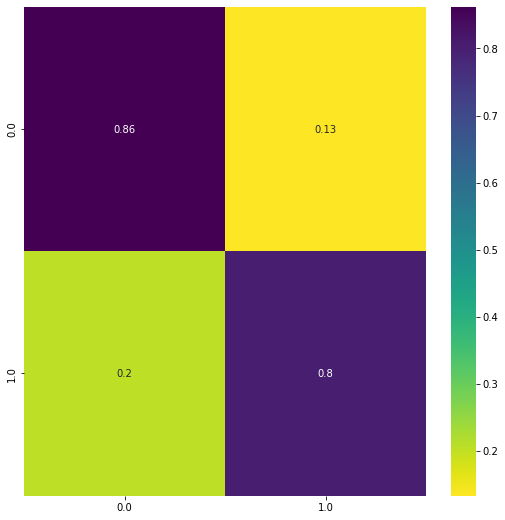

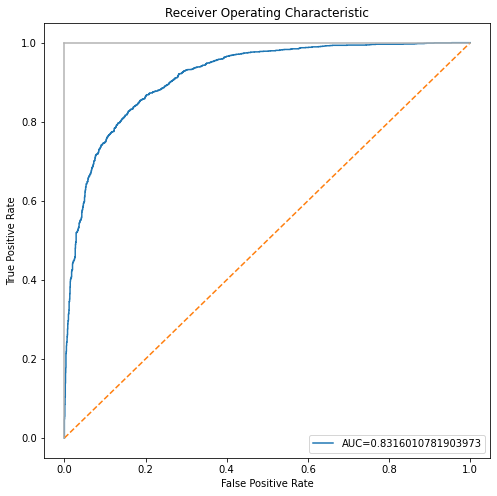

In [24]:
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The model is scoring as it did when run locally which is promising. Following this I'll define the function `optimal_model` to automate the process of training the model and saving its best instance. Also in the end the learning curve is plotted of the training and validation loss for each epoch.

In [25]:
# Function automating finding the best model
def optimal_model(device, model, epochs, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, display=False, clip_value = 0.6):

    # Variable initialisation
    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Train the model
        meanLoss = train_epoch(optimizer, scheduler, train_dataloader, lossfunc,  model, device, display, clip_value)

        # Evaluation
        _, _, _, meanlossval, accura, macrof1, _, _ = evaluation_function(val_dataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " Validation loss: ", meanlossval, " Accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += abs(meanLoss-meanlossval)
        
        # If f1 score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './best_model.pt')
    
        if(display):
            print("__________________________________")

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.plot(x, trainlosses, linestyle="-", label="Training")
    plt.plot(x, validlosses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    return bestepoch

Then I will increase the maximum sequence length to 128 to see if it has an increase in performance with the added information.

In [26]:
MAX_LENGTH = 128
BATCH_SIZE = 32

# Tokenizing, preprocessing and dataset creation
train_dataset = CustomDataset(train_X, indexed_labels_train, MAX_LENGTH)
val_dataset = CustomDataset(val_X, indexed_labels_val, MAX_LENGTH)
test_dataset = CustomDataset(test_X, indexed_labels_test, MAX_LENGTH)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Then training the model with the best parameters found for four epochs.

Epoch 1
__________________________________
loss: 0.675423  [    0/14402]
loss: 0.503699  [ 2048/14402]
loss: 0.558030  [ 4096/14402]
loss: 0.432924  [ 6144/14402]
loss: 0.626050  [ 8192/14402]
loss: 0.591076  [10240/14402]
loss: 0.573817  [12288/14402]
loss: 0.528501  [14336/14402]

Evaluation Results
_________________________________
Predicted 3559 / 4501 correctly
Mean Loss: 0.52 
Recall: 94.88%
Precision: 72.24%
Accuracy: 79.07%
Macro Averaged F1-score: 78.49%
_________________________________
Training loss:  0.5008584797514516  Validation loss:  0.5194904036978458  Accuracy:  79.07131748500333
__________________________________
Epoch 2
__________________________________
loss: 0.541289  [    0/14402]
loss: 0.432274  [ 2048/14402]
loss: 0.411143  [ 4096/14402]
loss: 0.432910  [ 6144/14402]
loss: 0.406710  [ 8192/14402]
loss: 0.364041  [10240/14402]
loss: 0.469602  [12288/14402]
loss: 0.515242  [14336/14402]

Evaluation Results
_________________________________
Predicted 3877 / 4501 c

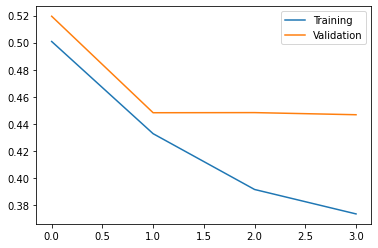

Best F1 score after  3  epochs.
Training Time: 21.63 minutes


In [27]:
EPOCHS = 4
HIDDEN_SIZE = 64
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
EPSILON = 1e-8
CLIP_VALUE = 0.6

# Instaniate the model
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
best_epoch = optimal_model(device, model, EPOCHS, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, True, CLIP_VALUE)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

With the increased sequence length the BERT-based classifier showed improved performance across all metrics. The learning curve indicates the importance of early stopping to combat overfitting, as the validation and training curves start to diverge after the second epoch. Then I'll be doing evaluation of the model on the test set to assess its generalization ability.


Evaluation Results
_________________________________
Predicted 3140 / 3601 correctly
Mean Loss: 0.44 
Recall: 85.68%
Precision: 88.47%
Accuracy: 87.20%
Macro Averaged F1-score: 87.20%
_________________________________


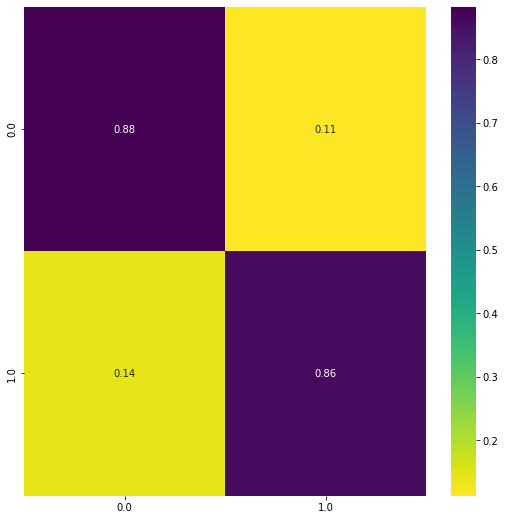

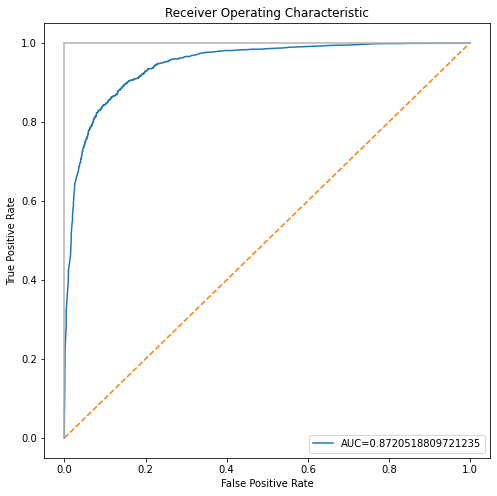

In [29]:
# Load the best model found before
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
model.load_state_dict(torch.load('./best_model.pt'))

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

It's obvious that the BERT-based classifier with increased sequence length and early stopping has significantly improved its performance, achieving an accuracy of 87.20% and a high recall of 85.68%. The high precision of 88.47% also indicates that the model is making fewer false positive predictions. The ROC curve shows that the classifier has a high true positive rate while keeping a low false positive rate. 

These results suggest that the increase in sequence length had the most impact on the performance of the model, so I will increase it further to 256. I'll also increase the training data to 65% of the dataset provided.

In [30]:
MAX_LENGTH = 256
BATCH_SIZE = 32

# I will reserve 8% of the samples for testing and 10% for validation
train_X, val_X, test_X = X[:int(len(X)*0.65)], X[int(len(X)*0.65):int(len(X)*0.75)], X[int(len(X)*0.75):int(len(X)*0.83)]
train_Y, val_Y, test_Y = Y[:int(len(Y)*0.65)], Y[int(len(Y)*0.65):int(len(Y)*0.75)], Y[int(len(Y)*0.75):int(len(Y)*0.83)]

# Unique returns the mapping sorted
labelsMapping, indexed_labels_train = np.unique(train_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_Y['rating'], return_inverse=True)

# Tokenizing, preprocessing and dataset creation
train_dataset = CustomDataset(train_X, indexed_labels_train, MAX_LENGTH)
val_dataset = CustomDataset(val_X, indexed_labels_val, MAX_LENGTH)
test_dataset = CustomDataset(test_X, indexed_labels_test, MAX_LENGTH)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Then training for four epochs with the best hyperparameters using the optimal model function to save the best instance of the model.

Epoch 1
__________________________________
loss: 0.679262  [    0/29255]
loss: 0.580526  [ 2048/29255]
loss: 0.550038  [ 4096/29255]
loss: 0.458751  [ 6144/29255]
loss: 0.471385  [ 8192/29255]
loss: 0.527364  [10240/29255]
loss: 0.377827  [12288/29255]
loss: 0.474845  [14336/29255]
loss: 0.430230  [16384/29255]
loss: 0.535394  [18432/29255]
loss: 0.594626  [20480/29255]
loss: 0.424480  [22528/29255]
loss: 0.430511  [24576/29255]
loss: 0.500040  [26624/29255]
loss: 0.440951  [28672/29255]

Evaluation Results
_________________________________
Predicted 4033 / 4501 correctly
Mean Loss: 0.41 
Recall: 93.29%
Precision: 86.66%
Accuracy: 89.60%
Macro Averaged F1-score: 89.60%
_________________________________
Training loss:  0.453558663690025  Validation loss:  0.41320371289625235  Accuracy:  89.60231059764496
__________________________________
Epoch 2
__________________________________
loss: 0.442765  [    0/29255]
loss: 0.345676  [ 2048/29255]
loss: 0.468192  [ 4096/29255]
loss: 0.371414  [

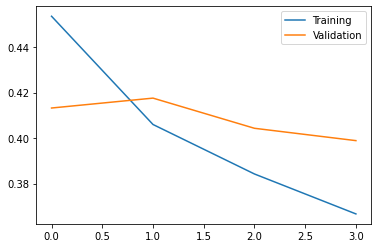

Best F1 score after  3  epochs.
Training Time: 84.81 minutes


In [31]:
EPOCHS = 4
HIDDEN_SIZE = 64
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
EPSILON = 1e-8
CLIP_VALUE = 0.6

# Instaniate the model
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
best_epoch = optimal_model(device, model, EPOCHS, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, True, CLIP_VALUE)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

Based on the learning curve, it appears that the model did not overfit the data, as it is much healthier than previous attempts. Also early stopping helps to avoid overfitting. 

It is worth noting that the training took 84 minutes, which may be considered lengthy, but it is understandable given the number of parameters of the BERT model and the size of the dataset.

Its performance on the validation during training was excellent and kept improving up to the third epoch. So this means that it stopped learning after this point. Also, it scored on the validation set well over 90% across all metrics. I'll then evaluate on the test set.


Evaluation Results
_________________________________
Predicted 3312 / 3600 correctly
Mean Loss: 0.39 
Recall: 92.50%
Precision: 91.48%
Accuracy: 92.00%
Macro Averaged F1-score: 92.00%
_________________________________


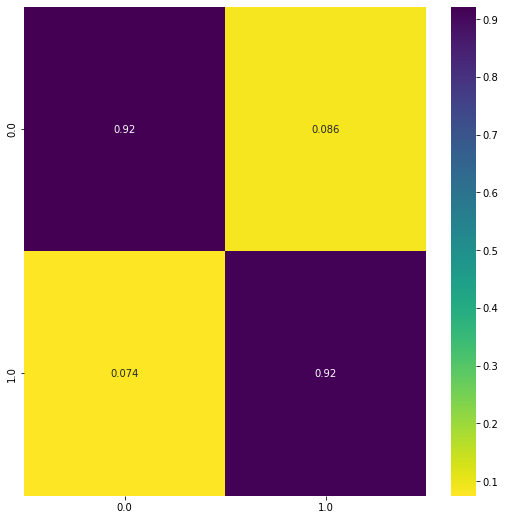

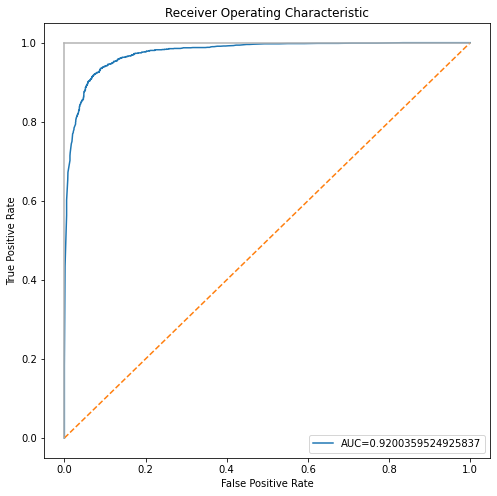

In [32]:
# Load the best model found before
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
model.load_state_dict(torch.load('./best_model.pt'))

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The accuracy on the test is 92.00% which is excellent and performed similarly across all the metrics and ROC-auc score. The macro-averaged F1-score of 92.00% also suggests that the model is able to correctly classify instances from both positive and negative sentiment with high accuracy. It is also better than the best LSTM/GRU networks I implemented which scored a bit under 91%. This shows the power of the BERT-based classifier and of the transformers model for sentiment analysis.